# Y3 Gold photometry plots

This notebook is intended to be used to create Y3 Gold paper plots: photometry

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#import fitsio
from astropy.io import fits
from astropy.io.fits.hdu.hdulist import HDUList
import healpy as hp
from descolors import BAND_COLORS
import warnings
warnings.filterwarnings('ignore')
matplotlib.style.use('des_dr1')
workdir = '/Users/nsevilla/y3gold-paper/'
datadir = workdir+'data/'
figsdir = workdir+'figs/'

In [2]:
#load Alex's skymap utilities
import skymap
from skymap import Skymap,McBrydeSkymap,OrthoSkymap
from skymap import SurveySkymap,SurveyMcBryde,SurveyOrtho
from skymap import DESSkymap

SKYMAPS = [Skymap,McBrydeSkymap,OrthoSkymap]
SURVEYS = [SurveySkymap,SurveyMcBryde,SurveyOrtho]

NSIDE = 128

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3

In [4]:
import scipy.optimize
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2./(2.*sigma**2))

/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indi

### Photometry residual map and histogram

In [1]:
# we will use the residual maps from Eli
# https://cdcvs.fnal.gov/redmine/projects/descalibration/wiki/FGCM_Y4A1_Zeropoints#Comparisons-to-Gaia-DR2

In [5]:
#Y3DR2_photo_residual_map = fits.open(datadir+'y4a1_y1-4_finalcut_ima_nostd_superfit1_map128.fits',memmap=True)
Y3DR2_photo_residual_map = fits.open(datadir+'y4a1_v1.5.0_gdr2ml3_maps128.fits',memmap=True)
Y3DR2_photo_residual_data = Y3DR2_photo_residual_map[1].data
#Y3DR2_photo_residual_map_old = fits.open(datadir+'y3a1_gaia_offsets_0515-nobs.fit',memmap=True)
#Y3DR2_photo_residual_data_old = Y3DR2_photo_residual_map_old[1].data


/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/sky

In [10]:
print(Y3DR2_photo_residual_data.columns)

ColDefs(
    name = 'hpix'; format = 'K'
    name = 'offset_G_r'; format = 'E'
    name = 'err_G_r'; format = 'E'
    name = 'nobs_G_r'; format = 'J'
    name = 'nstar_G_r'; format = 'J'
    name = 'ntot_G_r'; format = 'J'
    name = 'nout3_G_r'; format = 'J'
    name = 'nout4_G_r'; format = 'J'
)


In [6]:
mask = (Y3DR2_photo_residual_data['NSTAR'] >= 10)
pix = Y3DR2_photo_residual_data['HPIX'][mask]
offset = Y3DR2_photo_residual_data['OFFSET'][mask]*1000
### for outliers
#mask = (Y3DR2_photo_residual_data['nstar_G_r'] >= 10)
#pix = Y3DR2_photo_residual_data['hpix']
#outliers = Y3DR2_photo_residual_data['nout3_G_r']
#nstars = Y3DR2_photo_residual_data['ntot_G_r']
#ratio = outliers/nstars

/anaconda2/envs/skymap/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4759: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


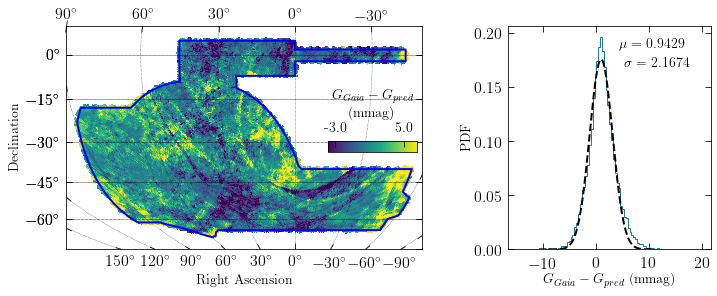

In [8]:
fig = plt.figure(figsize=(12.,4.))
#fig.suptitle('Photometric 3-sigma outliers vs Gaia DR2 stars in mags', fontsize = 22, y=1.08)
#fig.suptitle('Photometric uniformity vs Gaia DR2 stars in mmags', fontsize = 22, y=1.08)
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
smap = DESSkymap()
#smap.draw_hpxmap(ratio.byteswap().newbyteorder(),pix.byteswap().newbyteorder(),NSIDE,xsize=1000)
#smap.draw_inset_colorbar(fontsize=14,ticks=[0.05,2])
smap.draw_hpxmap(offset.byteswap().newbyteorder(),pix.byteswap().newbyteorder(),NSIDE,xsize=1000)
smap.draw_inset_colorbar(fontsize=14,ticks=[-3,5],label='$G_{Gaia}-G_{pred}$ \n (mmag)')
smap.draw_des()
ax2 = plt.subplot(gs[1])
fig.add_subplot(ax2)
plt.sca(ax2)
#plt.xlabel(r'Ratio of 3-sigma outliers in pixel')
plt.xlabel(r'$G_{Gaia}-G_{pred} $ (mmag)')
plt.ylabel('PDF',labelpad=1)
#plt.yscale('log')
#n,b,p = plt.hist(ratio,normed=True,histtype='step',bins=100, range=[0,1])
n,b,p = plt.hist(offset,normed=True,histtype='step',bins=100, range=[-15,20])
hist_fit_x = (np.array(b[0:-1])+np.array(b[1:]))/2.
hist_fit_y = np.array(n)
p0 = [offset.size, np.mean(offset), np.std(offset)]
coeff,var_matrix = scipy.optimize.curve_fit(gauss, hist_fit_x, hist_fit_y, p0=p0)
xvals = np.linspace(-5*coeff[2],5*coeff[2],1000)
yvals = gauss(xvals,*coeff)
plt.plot(xvals,yvals,'k--',linewidth=2)
text1 = r'$\mu = %.4f$' % coeff[1]
text2 = r'$\sigma = %.4f$' % coeff[2]
ax2.annotate(text1,(0.55,0.95),xycoords='axes fraction',ha='left',va='top',size=14)
ax2.annotate(text2,(0.57,0.87),xycoords='axes fraction',ha='left',va='top',size=14)
#plt.savefig(figsdir+'y3gold_photometry_3s_outliers.png',bbox_inches='tight')
plt.savefig(figsdir+'y3gold_photometry_residuals.pdf',bbox_inches='tight',dpi=300)